In [42]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [43]:
path = '/Users/yuqianxie/Desktop/DS_proj_analysis/dataset'
os.chdir(path)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/yuqianxie/Desktop/DS_proj_analysis/dataset


In [44]:
data = pd.read_excel('Merged_Sorted_Data_Herd_Daily.xlsx')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values('Date')
data = data[['Date', 'Total Amount of Milk Produced']].dropna()
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Normalized Milk'] = scaler.fit_transform(data[['Total Amount of Milk Produced']])

In [45]:
# Function to create features and labels
def create_features(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data.iloc[i - look_back:i]['Normalized Milk'].values)
        y.append(data.iloc[i]['Normalized Milk'])
    return np.array(X), np.array(y)

# Define look back
look_back = min(len(data), 2920)
X, y = create_features(data, look_back)

# Chronological split of data (e.g., train on data up to 2024, forecast from 2025)
train_end_date = '2024-12-31'
train_indices = data[data['Date'] <= train_end_date].index[-1] - look_back
X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]


model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
predictions_test_rf = model_rf.predict(X_test)

# Calculate the Mean Squared Error
mse_rf = mean_squared_error(y_test, predictions_test_rf)
print("Mean Squared Error on Test Set:", mse_rf)

# Forecasting the next 10 years
model_rf.fit(X, y) 
predictions_rf = []
current_features = X[-1].reshape(1, -1)

for _ in range(3650):
    pred = model_rf.predict(current_features)
    predictions_rf.append(pred[0])
    current_features = np.append(current_features[:, 1:], pred).reshape(1, -1)

predictions_rf = scaler.inverse_transform(np.array(predictions_rf).reshape(-1, 1))
# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=pd.to_datetime('2025-01-01'), periods=3650, freq='D')
forecast_df_rf = pd.DataFrame(data={'Date': forecast_dates, 'Forecasted Milk Production': predictions_rf.flatten()})
forecast_df_rf.to_csv('forecast_random_forest_2025_2035.csv', index=False)

Mean Squared Error on Test Set: 6.916078924926694e-05


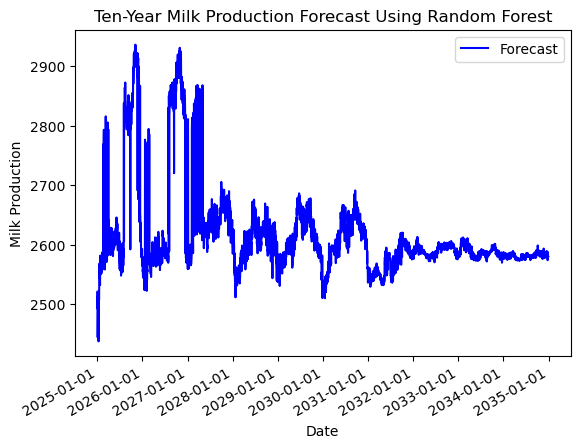

In [55]:
plt.plot(forecast_dates, predictions_rf.flatten(), label='Forecast', color='blue')
plt.title('Ten-Year Milk Production Forecast Using Random Forest')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()